In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import ruptures as rpt

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/processed/chunked_with_changepoints.csv")

def parse_embedding(s):
    s_clean = s.strip("[]")
    return np.fromstring(s_clean, sep=" ")

df["embedding"] = df["embedding"].apply(parse_embedding)

In [3]:
def extract_features(embeddings):
    novelties = []
    for i in range(1, len(embeddings)):
        sim = cosine_similarity([embeddings[i]], [embeddings[i-1]])[0][0]
        novelties.append(1 - sim)
    mean_novelty = np.mean(novelties) if novelties else 0
    var_novelty = np.var(novelties) if novelties else 0

    # Change point detection
    num_cps = 0
    last_cp = 0
    if len(embeddings) >= 3:
        try:
            series = np.vstack(embeddings)
            model_cp = rpt.Pelt(model="rbf").fit(series)
            change_points = model_cp.predict(pen=6)
            num_cps = len(change_points) - 1
            last_cp = change_points[-2] if len(change_points) > 1 else 0
        except Exception as e:
            num_cps = 0
            last_cp = 0

    return mean_novelty, var_novelty, num_cps, last_cp

In [4]:
feature_rows = []
target_rows = []

for video_title, group in df.groupby("VideoTitle"):
    group = group.reset_index(drop=True)
    total_chunks = len(group)
    embeddings = list(group["embedding"])
    for i in range(3, total_chunks):  # start after a few chunks
        mean_novelty, var_novelty, num_cps, last_cp = extract_features(embeddings[:i])
        # Features: [normalized chunk idx (using avg), mean novelty, var novelty, num_cps, last_cp/avg]
        features = [i / total_chunks, mean_novelty, var_novelty, num_cps, last_cp / total_chunks if total_chunks > 0 else 0]
        feature_rows.append(features)
        # Target: true completion %
        target_rows.append((i / total_chunks) * 100)

In [ ]:
# average speech length from training data
avg_speech_len = int(np.mean([len(g) for _, g in df.groupby("VideoTitle")]))
print(f"Average speech length (in chunks): {avg_speech_len}")

Average speech length (in chunks): 39


In [6]:
X = np.array(feature_rows)
y = np.array(target_rows)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
import joblib
joblib.dump(reg, "../model/random_forest_model.pkl")

['../model/random_forest_model.pkl']

In [ ]:
# real-time simulation by using avg_speech_len for normalization, NOT the true length
X_test_predictive = X_test.copy()
X_test_predictive[:,0] = X_test_predictive[:,0] * avg_speech_len  
X_test_predictive[:,0] = X_test_predictive[:,0] / avg_speech_len  
X_test_predictive[:,4] = X_test_predictive[:,4] * avg_speech_len  
X_test_predictive[:,4] = X_test_predictive[:,4] / avg_speech_len  
y_pred = reg.predict(X_test_predictive)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f"Predictive MAE: {mae:.2f}%")
print(f"Predictive RMSE: {rmse:.2f}%")

Predictive MAE: 0.02%
Predictive RMSE: 0.03%


In [ ]:
def predict_progress_live(partial_embeddings, reg_model, avg_speech_len):
    i = len(partial_embeddings)
    if i < 3:
        return 5.0
    mean_novelty, var_novelty, num_cps, last_cp = extract_features(partial_embeddings)
    # normalize by avg_speech_len, NOT true length
    features = [i / avg_speech_len, mean_novelty, var_novelty, num_cps, last_cp / avg_speech_len]
    pred = reg_model.predict([features])[0]
    return min(max(pred, 0), 100)

In [11]:
video_title = "75th UN General Assembly Speech"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

# Predict for first 8 chunks (simulate real-time)
partial_embeddings = list(sample_group["embedding"][:8])
predicted_progress = predict_progress_live(partial_embeddings, reg, avg_speech_len)
print(f"Predicted Speech Completion (predictive): {predicted_progress:.2f}%")

# True completion for reference (not used in prediction)
true_progress = (8 / len(sample_group)) * 100
print(f"True Completion at chunk 8: {true_progress:.2f}%")

Predicted Speech Completion (predictive): 20.52%
True Completion at chunk 8: 18.60%


In [12]:
for i in range(3, len(sample_group)+1):
    partial_embeddings = list(sample_group["embedding"][:i])
    pred = predict_progress_live(partial_embeddings, reg, avg_speech_len)
    true_pct = (i / len(sample_group)) * 100
    print(f"Chunks: {i:2d} | Predicted: {pred:6.2f}% | True: {true_pct:6.2f}%")

Chunks:  3 | Predicted:   7.70% | True:   6.98%
Chunks:  4 | Predicted:  10.26% | True:   9.30%
Chunks:  5 | Predicted:  12.82% | True:  11.63%
Chunks:  6 | Predicted:  15.38% | True:  13.95%
Chunks:  7 | Predicted:  17.96% | True:  16.28%
Chunks:  8 | Predicted:  20.52% | True:  18.60%
Chunks:  9 | Predicted:  23.07% | True:  20.93%
Chunks: 10 | Predicted:  25.65% | True:  23.26%
Chunks: 11 | Predicted:  28.19% | True:  25.58%
Chunks: 12 | Predicted:  30.77% | True:  27.91%
Chunks: 13 | Predicted:  33.33% | True:  30.23%
Chunks: 14 | Predicted:  35.94% | True:  32.56%
Chunks: 15 | Predicted:  38.47% | True:  34.88%
Chunks: 16 | Predicted:  41.01% | True:  37.21%
Chunks: 17 | Predicted:  43.60% | True:  39.53%
Chunks: 18 | Predicted:  46.15% | True:  41.86%
Chunks: 19 | Predicted:  48.74% | True:  44.19%
Chunks: 20 | Predicted:  51.26% | True:  46.51%
Chunks: 21 | Predicted:  53.85% | True:  48.84%
Chunks: 22 | Predicted:  56.41% | True:  51.16%
Chunks: 23 | Predicted:  58.98% | True: 

In [13]:
print(df["VideoTitle"].unique())

['Muniba_Mazari' 'RIHANNA' 'Mr_Bean' 'Nita_Ambani' 'Joe_Biden'
 'Sara_Ali_Khan' 'Michelle_Obama' 'Mother_Teresa' 'Boris_Johnson'
 'Elon_Musk' 'Jeff_Bezos' 'Justin_Trudeau' 'Shereen_Salama'
 'Angelina_Jolie' 'Queen_Elizabeth' 'Kate_Winslet' 'Denzel_Washington'
 'Jennifer_Lawrence' 'R_Madhavan' 'Tim_Cook' 'Anne_Hathaway'
 'Nelson_Mandela' 'Demi_Lovato' 'Severn_Suzuki' 'Arnold_Schwarzenegger'
 'Steven_Spielberg' 'Glenn_Close' 'Kristen_Bell' 'JD_Vance'
 'Emotional Eulogy for His Father' 'Serve Humanity' 'Be Funny, Be You'
 'Emotional Speech' 'Stand Up and Speak Up' 'HeForShe Impact'
 'The Power of Information' 'Why Not Me?' 'Be Thankful'
 'First Speech as King ' 'Be Present!' 'We Are All History' "We're Bound"
 'Be Nice!' 'India vs Pakistan at the UN' 'The Pursuit of Happiness'
 '5 Rules for Success' 'Survival Mode' 'Will You Join Us?'
 '9 Life Lessons' 'Mega Mass Party 2023' 'Transforming India'
 'Protecting Our Planet' '3 Forms of Listening' 'Be Brave, Not Perfect '
 'Tribute to Kobe Bry

In [14]:
video_title = "Education Changes the World"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

# Predict for first 8 chunks (simulate real-time)
partial_embeddings = list(sample_group["embedding"][:20])
predicted_progress = predict_progress_live(partial_embeddings, reg, avg_speech_len)
print(f"Predicted Speech Completion (predictive): {predicted_progress:.2f}%")

# True completion for reference (not used in prediction)
true_progress = (8 / len(sample_group)) * 100
print(f"True Completion at chunk 8: {true_progress:.2f}%")

Predicted Speech Completion (predictive): 38.47%
True Completion at chunk 8: 53.33%


In [15]:
video_title = "India-Australia Partnership"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

# Predict for first 8 chunks (simulate real-time)
partial_embeddings = list(sample_group["embedding"][:8])
predicted_progress = predict_progress_live(partial_embeddings, reg, avg_speech_len)
print(f"Predicted Speech Completion (predictive): {predicted_progress:.2f}%")

# True completion for reference (not used in prediction)
true_progress = (8 / len(sample_group)) * 100
print(f"True Completion at chunk 8: {true_progress:.2f}%")

Predicted Speech Completion (predictive): 20.58%
True Completion at chunk 8: 24.24%


In [16]:
video_title = "India's Five Pledges"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

# Predict for first 8 chunks (simulate real-time)
partial_embeddings = list(sample_group["embedding"][:8])
predicted_progress = predict_progress_live(partial_embeddings, reg, avg_speech_len)
print(f"Predicted Speech Completion (predictive): {predicted_progress:.2f}%")

# True completion for reference (not used in prediction)
true_progress = (8 / len(sample_group)) * 100
print(f"True Completion at chunk 8: {true_progress:.2f}%")

Predicted Speech Completion (predictive): 20.57%
True Completion at chunk 8: 22.22%


In [17]:
video_title = "The Power Of Words"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

# Predict for first 8 chunks (simulate real-time)
partial_embeddings = list(sample_group["embedding"][:8])
predicted_progress = predict_progress_live(partial_embeddings, reg, avg_speech_len)
print(f"Predicted Speech Completion (predictive): {predicted_progress:.2f}%")

# True completion for reference (not used in prediction)
true_progress = (8 / len(sample_group)) * 100
print(f"True Completion at chunk 8: {true_progress:.2f}%")

Predicted Speech Completion (predictive): 20.54%
True Completion at chunk 8: 32.00%


In [24]:
video_title = "How to Face Fear"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

# Predict for first 8 chunks (simulate real-time)
partial_embeddings = list(sample_group["embedding"][:8])
predicted_progress = predict_progress_live(partial_embeddings, reg, avg_speech_len)
print(f"Predicted Speech Completion (predictive): {predicted_progress:.2f}%")

# True completion for reference (not used in prediction)
true_progress = (8 / len(sample_group)) * 100
print(f"True Completion at chunk 8: {true_progress:.2f}%")

Predicted Speech Completion (predictive): 20.58%
True Completion at chunk 8: 14.55%


In [25]:
import matplotlib.pyplot as plt

In [26]:
# Select the speech to visualize
video_title = "How to Face Fear"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

# Lists to store predictions and true completion percentages
predicted_progress_list = []
true_progress_list = []
chunk_indices = list(range(3, len(sample_group) + 1))

# Generate predictions for each chunk count (simulate real-time)
for i in chunk_indices:
    partial_embeddings = list(sample_group["embedding"][:i])
    pred = predict_progress_live(partial_embeddings, reg, avg_speech_len)
    true_pct = (i / len(sample_group)) * 100
    predicted_progress_list.append(pred)
    true_progress_list.append(true_pct)

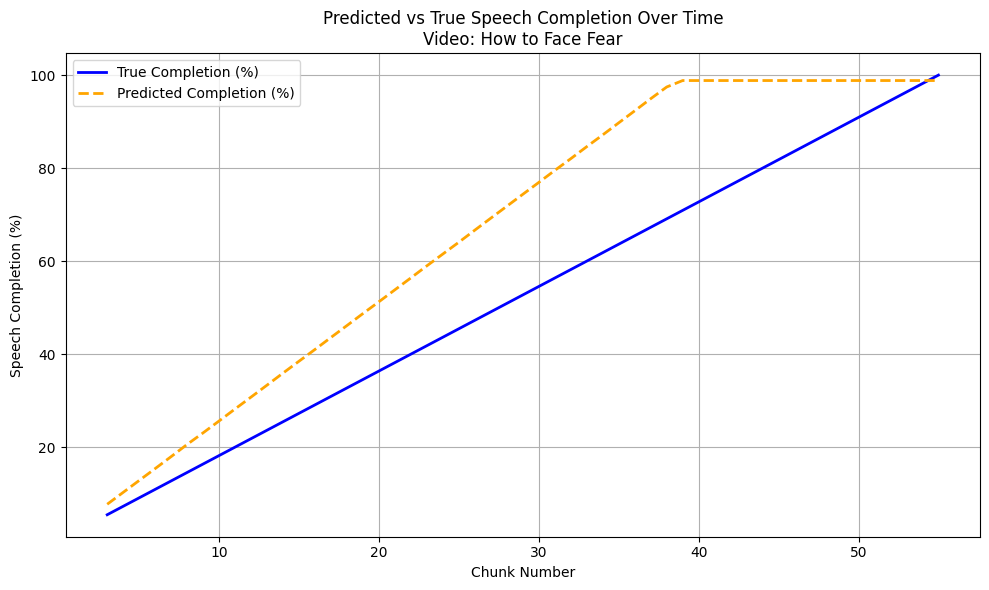

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(chunk_indices, true_progress_list, label='True Completion (%)', color='blue', linewidth=2)
plt.plot(chunk_indices, predicted_progress_list, label='Predicted Completion (%)', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Chunk Number')
plt.ylabel('Speech Completion (%)')
plt.title(f"Predicted vs True Speech Completion Over Time\nVideo: {video_title}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()